1. Discussion and Background of the Business Problem

**Introduction Section**

This final project explores the best locations for Chinese restaurants throughout the Queens of New York. New york is a major metropolitan area with more than 8.4 million (Quick Facts, 2018) people living within city limits. New York City is the largest city in the united states with a long history of international immigration. The New York metropolitan area is home to the largest and most prominent ethnic Chinese population outside of Asia, hosting Chinese populations representing all 34 provincial-level administrative units of China and constituting the largest metropolitan Asian American group in the United States as well as the largest Asian-national metropolitan diaspora in the Western Hemisphere. The Chinese American population of the New York City metropolitan area was an estimated 893,697 as of 2017. New York City itself contains by far the highest ethnic Chinese population of any individual city outside Asia, estimated at 628,763 as of 2017.



**Target Audience**



*   Business personnel who wants to invest or open a restaurant in New York
*   The freelancer who loves to have their own restaurant as a side business
*   Finding the best location for opening a restuarant
*   Budding data Scientists, who want to implement some of the most used






**Data Section**

For this project, we need the following data:
1. New York city data that contains Borough, Neighborhoods alongwith there latitude and longitude


*   Data Souce: https://cocl.us/new_york_dataset
*   Description: This data set contains the required information. We can use this data set to explore various neighborhoods of new York city.

2. Chinese restaurants in Queens neighborhood of New York City

*   Data Source: Foursquare API
*   Description: by using this API we can get all the venues in the Queens neighborhood. We can filter these venues to get only chinese restaurants





**Approach**

1. collect New York city data from  https://cocl.us/new_york_dataset
2. Using Foursquare API, we will get all venues for each neighborhood
3. Filter out all venues which are Chinese restuarants
3. Data visualization and statistical analysis
4. Analyzing using KMeans clustering
5. compare the Neighborhoods to find the best place for starting up a restautant
6. Inference from these results and related conclusions

**Problem Statement**

1. what is the best location for a Chinese restaurant in Queens, New York City?
2. In what Neighborhood should I open a Chinese restaurant to have the best chance of being successful?


2. Data preparation


In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

In [2]:
!wget -q -O 'newyork_data.json'  https://cocl.us/new_york_dataset

with open('newyork_data.json') as json_data:
  newyork_data=json.load(json_data)
ny_data=newyork_data['features']

# define the dataframe columns
column_names=['Borough','Neighborhood','Latitude','Longitude']

# instantiate the dataframe
newyork=pd.DataFrame(columns=column_names)
newyork

,Borough,Neighborhood,Latitude,Longitude


In [31]:
for data in ny_data:
  borough=data['properties']['borough']
  neighborhood_name=data['properties']['name']

  neighborhood_latlon=data['geometry']['coordinates']
  neighborhood_lat=neighborhood_latlon[1]
  neighborhood_lon=neighborhood_latlon[0]

  newyork=newyork.append({'Borough':borough,
                                      'Neighborhood': neighborhood_name,
                                      'Latitude': neighborhood_lat,
                                      'Longitude': neighborhood_lon}, ignore_index=True)

In [32]:
newyork.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [33]:
#print(newyork['Borough'].unique)
Queens_data=newyork[newyork['Borough']=="Queens"].reset_index(drop=True)
Queens_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


I will use geopy library to get coordinates of Queens, New York

In [6]:
address="Queens, NY"
geolocator=Nominatim(user_agent='ny_explorer')
location=geolocator.geocode(address)
latitude=location.latitude
longitude=location.longitude
print('The geograpical coordinate of Queens are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Queens are 40.7498243, -73.7976337.


Using Foursquare Location Data:

Foursquare data is very comprehensive and it powers location data for Apple, Uber, etc. For this business problem I have used, as a part of the assignment, the Foursquare API to retrieve information about the Venue, Venue category with their longitudes and latitudes. The call returns a JSON file and we need to turn that into a data-frame. Here I’ve chosen 100 popular spots for each neighborhood with a radius of 500 meters. Below is the data-frame obtained from the JSON file that was returned by

In [7]:
CLIENT_ID = 'O2PWZOLMNH34NYKB5ELZVLAIT52AMBZXYNC0GA5V4CX4ZZ14' # your Foursquare ID
CLIENT_SECRET = 'JQS4ZVFGSLU1HXDHJWQ1EIG242RSBGKNYA4W5ES3ZI5H0VZN' # your Foursquare Secret
ACCESS_TOKEN = '02FYX3DUPLK3BOBFSTZPNT5AVXMPOZWDFR2O2IZSFLHWI3YI' # your FourSquare Access Token
VERSION = '20180604'
LIMIT=100


# Explore neighborhoods in Queens
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
Queens_venues=getNearbyVenues(names=newyork['Neighborhood'],
                              latitudes=newyork['Latitude'],
                              longitudes=newyork['Longitude']
                             )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [9]:
print(Queens_venues.shape)
Queens_venues.head()
#print(Queens_venues['Venue Category'].unique())

(10100, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Subway,40.890468,-73.849152,Sandwich Place


Exploratory Data

In [10]:
queens_onehot=pd.get_dummies(Queens_venues[['Venue Category']],prefix="",prefix_sep="")

columns_names1=queens_onehot.columns
print(columns_names1)
for ls in columns_names1:
  if "Restaurant" in ls:
    print(ls)


Index(['ATM', 'Accessories Store', 'Adult Boutique', 'Afghan Restaurant',
       'African Restaurant', 'Airport Terminal', 'American Restaurant',
       'Antique Shop', 'Arcade', 'Arepa Restaurant',
       ...
       'Warehouse Store', 'Waste Facility', 'Waterfront', 'Weight Loss Center',
       'Whisky Bar', 'Wine Bar', 'Wine Shop', 'Wings Joint', 'Women's Store',
       'Yoga Studio'],
      dtype='object', length=438)
Afghan Restaurant
African Restaurant
American Restaurant
Arepa Restaurant
Argentinian Restaurant
Asian Restaurant
Australian Restaurant
Austrian Restaurant
Brazilian Restaurant
Burmese Restaurant
Cajun / Creole Restaurant
Cantonese Restaurant
Caribbean Restaurant
Caucasian Restaurant
Chinese Restaurant
Colombian Restaurant
Comfort Food Restaurant
Cuban Restaurant
Czech Restaurant
Dim Sum Restaurant
Dumpling Restaurant
Eastern European Restaurant
Empanada Restaurant
English Restaurant
Ethiopian Restaurant
Falafel Restaurant
Fast Food Restaurant
Filipino Restaurant
Frenc

There are many different chinese categories food. Let me extact all of them to columns_names2

In [11]:
columns_names2=["Asian Restaurant","Cantonese Restaurant","Chinese Restaurant","Dumpling Restaurant","Hotpot Restaurant","Shanghai Restaurant","Szechuan Restaurant"]
queens_chinese=queens_onehot[columns_names2]
queens_chinese['Neighborhood']=Queens_venues[['Neighborhood']]
fixed_columns=[queens_chinese.columns[-1]]+list(queens_chinese.columns[:-1])
queens_chinese=queens_chinese[fixed_columns]
print(queens_chinese.shape)
queens_chinese.head()

(10100, 8)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Neighborhood,Asian Restaurant,Cantonese Restaurant,Chinese Restaurant,Dumpling Restaurant,Hotpot Restaurant,Shanghai Restaurant,Szechuan Restaurant
0,Wakefield,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0


In [50]:
queens_grouped=queens_chinese.groupby('Neighborhood').mean().reset_index()
queens_grouped.head()

,Neighborhood,Asian Restaurant,Cantonese Restaurant,Chinese Restaurant,Dumpling Restaurant,Hotpot Restaurant,Shanghai Restaurant,Szechuan Restaurant
0,Allerton,0.0,0.0,0.071429,0.0,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,Arrochar,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [13]:
queens_grouped.shape

(300, 8)

In [48]:
queens_grouped2=queens_chinese.groupby('Neighborhood').sum().reset_index()
queens_grouped3=queens_grouped2.sum()
queens_grouped3

Neighborhood            AllertonAnnadaleArden HeightsArlingtonArrochar...
Asian Restaurant                                                       48
Cantonese Restaurant                                                    4
Chinese Restaurant                                                    222
Dumpling Restaurant                                                    10
Hotpot Restaurant                                                      13
Shanghai Restaurant                                                     8
Szechuan Restaurant                                                     5
dtype: object

There are 222 chinese restaurants and 48 Asian Restaurants. The other category is seldom. To simplifies our analization, we can neglect Cantonese Restaurant, Dumpling Restaurant, Hotpot Restaurant, Shanghai Restaurant, Szechuan Restaurant

In [55]:
columns_names2=["Asian Restaurant","Chinese Restaurant"]
queens_chinese=queens_onehot[columns_names2]
queens_chinese['Neighborhood']=Queens_venues[['Neighborhood']]
fixed_columns=[queens_chinese.columns[-1]]+list(queens_chinese.columns[:-1])
queens_chinese=queens_chinese[fixed_columns]
print(queens_chinese.shape)
queens_chinese.head()

(10100, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Neighborhood,Asian Restaurant,Chinese Restaurant
0,Wakefield,0,0
1,Wakefield,0,0
2,Wakefield,0,0
3,Wakefield,0,0
4,Wakefield,0,0


In [116]:
queens_grouped=queens_chinese.groupby('Neighborhood').mean().reset_index()
queens_grouped.head()

,Neighborhood,Asian Restaurant,Chinese Restaurant
0,Allerton,0.0,0.071429
1,Annadale,0.0,0.000000
2,Arden Heights,0.0,0.000000
3,Arlington,0.0,0.000000
4,Arrochar,0.0,0.000000


Run k-means

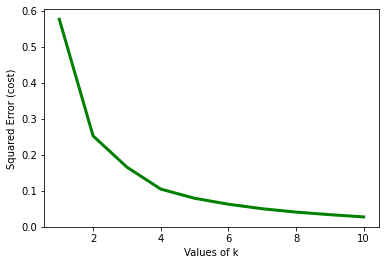

In [57]:
cost=[]
queens_grouped_clustering=queens_grouped.drop('Neighborhood',1)
for kcluster in range(1,11):
  kmeans=KMeans(n_clusters=kcluster,random_state=43).fit(queens_grouped_clustering)
  cost.append(kmeans.inertia_)

# plot the cost against K values
plt.plot(range(1,11),cost,color='g',linewidth=3)
plt.xlabel('Values of k')
plt.ylabel('Squared Error (cost)')
plt.show()


#kmeans.labels_[0:10]

In [117]:
kcluster=3
kmeans=KMeans(n_clusters=kcluster,random_state=0).fit(queens_grouped_clustering)

From the above image, we see that the best value of k will be 3, where the elbow appears

Next, we will add the coordinates and kmean labels to the data frame

In [118]:
queens_grouped.insert(0,'Cluster Labels', kmeans.labels_)
queens_merged=Queens_data
queens_merged=queens_merged.join(queens_grouped.set_index('Neighborhood'),on='Neighborhood')
queens_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Asian Restaurant,Chinese Restaurant
0,Queens,Astoria,40.768509,-73.915654,1,0.0,0.010101
1,Queens,Woodside,40.746349,-73.901842,1,0.0,0.024390
2,Queens,Jackson Heights,40.751981,-73.882821,1,0.0,0.000000
3,Queens,Elmhurst,40.744049,-73.881656,2,0.0,0.062500
4,Queens,Howard Beach,40.654225,-73.838138,2,0.0,0.055556


In [100]:
queens_merged['Neighborhood'].unique

<bound method Series.unique of 0                   Astoria
1                  Woodside
2           Jackson Heights
3                  Elmhurst
4              Howard Beach
5                    Corona
6              Forest Hills
7               Kew Gardens
8             Richmond Hill
9                  Flushing
10         Long Island City
11                Sunnyside
12            East Elmhurst
13                  Maspeth
14                Ridgewood
15                 Glendale
16                Rego Park
17                Woodhaven
18               Ozone Park
19         South Ozone Park
20            College Point
21               Whitestone
22                  Bayside
23               Auburndale
24              Little Neck
25               Douglaston
26                Glen Oaks
27                Bellerose
28        Kew Gardens Hills
29            Fresh Meadows
30                Briarwood
31           Jamaica Center
32          Oakland Gardens
33           Queens Village
34               

visualize the resulting clusters

In [119]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kcluster)
ys = [i + x + (i*x)**2 for i in range(kcluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(queens_merged['Latitude'], queens_merged['Longitude'], queens_merged['Neighborhood'], queens_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's examine the cluster
Here, we have 4 clusters 0, 1, 2, and 3 respectively. 


In [172]:
# cluster 0
#cluster0=queens_merged[queens_merged['Cluster Labels']==0].sum(axis=0).to_frame().drop(["Borough","Neighborhood","Latitude","Longitude","Cluster Labels"]).reset_index()
#cluster0.columns=["Restaurant Category","Mean"]
#cluster0.head()

queens_grouped.loc[queens_grouped['Cluster Labels']==0]


,Cluster Labels,Neighborhood,Asian Restaurant,Chinese Restaurant
18,0,Beechhurst,0.000000,0.117647
19,0,Bellaire,0.000000,0.166667
23,0,Bensonhurst,0.031250,0.125000
34,0,Bronxdale,0.000000,0.153846
54,0,Claremont Village,0.000000,0.142857
77,0,East Flatbush,0.000000,0.181818
107,0,Fresh Meadows,0.000000,0.142857
127,0,High Bridge,0.038462,0.115385
197,0,Oakland Gardens,0.000000,0.125000
220,0,Queensboro Hill,0.047619,0.142857


In [173]:
# cluster 1
#cluster1=queens_merged[queens_merged['Cluster Labels']==1].sum(axis=0).to_frame().drop(["Borough","Neighborhood","Latitude","Longitude","Cluster Labels"]).reset_index()
#cluster1.columns=["Restaurant Category","Mean"]
#cluster1.head()
queens_grouped.loc[queens_grouped['Cluster Labels']==1]

,Cluster Labels,Neighborhood,Asian Restaurant,Chinese Restaurant
1,1,Annadale,0.000000,0.000000
2,1,Arden Heights,0.000000,0.000000
3,1,Arlington,0.000000,0.000000
4,1,Arrochar,0.000000,0.000000
5,1,Arverne,0.000000,0.000000
6,1,Astoria,0.000000,0.010101
7,1,Astoria Heights,0.000000,0.000000
8,1,Auburndale,0.000000,0.000000
10,1,Battery Park City,0.000000,0.013158
11,1,Bay Ridge,0.012658,0.025316


In [175]:
# cluster 2
#cluster2=queens_merged[queens_merged['Cluster Labels']==2].sum(axis=0).to_frame().drop(["Borough","Neighborhood","Latitude","Longitude","Cluster Labels"]).reset_index()
#cluster2.columns=["Restaurant Category","Mean"]
#cluster2.head()
queens_grouped.loc[queens_grouped['Cluster Labels']==2]

,Cluster Labels,Neighborhood,Asian Restaurant,Chinese Restaurant
0,2,Allerton,0.000000,0.071429
9,2,Bath Beach,0.019608,0.058824
16,2,Bedford Park,0.000000,0.083333
20,2,Belle Harbor,0.000000,0.055556
21,2,Bellerose,0.000000,0.052632
28,2,Borough Park,0.000000,0.045455
37,2,Brownsville,0.000000,0.071429
38,2,Bulls Head,0.000000,0.068182
41,2,Cambria Heights,0.000000,0.071429
47,2,Central Harlem,0.000000,0.046512


Ranking the density of restaraurant descendly, 

cluster 0 (highest)

cluster 2 (medium)

cluster 1 (low)



In [176]:
cluster0=queens_grouped[queens_grouped['Cluster Labels']==0]
cluster0.sort_values(by="Chinese Restaurant",ascending=False,inplace=True)
cluster0.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Cluster Labels,Neighborhood,Asian Restaurant,Chinese Restaurant
292,0,Willowbrook,0.0,0.285714
77,0,East Flatbush,0.0,0.181818
249,0,Soundview,0.0,0.176471
19,0,Bellaire,0.0,0.166667
34,0,Bronxdale,0.0,0.153846


In [177]:
queens_chinese[queens_chinese['Neighborhood']=='Willowbrook']

,Neighborhood,Asian Restaurant,Chinese Restaurant
9748,Willowbrook,0,1
9749,Willowbrook,0,0
9750,Willowbrook,0,1
9751,Willowbrook,0,0
9752,Willowbrook,0,0
9753,Willowbrook,0,0
9754,Willowbrook,0,0


Willowbrook has the highest density of chinese restaurant, but it only has two chinese restaurants.

let's visualize maximum number of Chinese restaurant

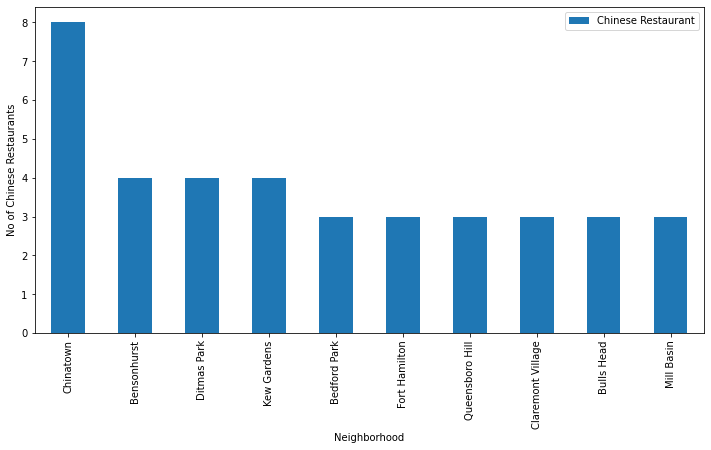

In [135]:
graph=pd.DataFrame(queens_chinese.groupby('Neighborhood')['Chinese Restaurant'].sum())
graph=graph.sort_values(by='Chinese Restaurant',ascending=False)
graph.iloc[:10].plot(kind='bar',figsize=(12,6))
plt.xlabel('Neighborhood')
plt.ylabel('No of Chinese Restaurants')
plt.show()

In [178]:
queens_grouped.loc[queens_grouped['Neighborhood']=='Chinatown']

,Cluster Labels,Neighborhood,Asian Restaurant,Chinese Restaurant
50,2,Chinatown,0.02,0.08


we see that Chinatown has the highest number of chinese restuarant. But Chinatown belongs to cluster 2, which has a medium density. Willowbrook has the highest density, but it only has 2 chinese restaurants. The reason could be that the total number of shops in cluster 0 is small, which produces a large density. An in the cluster 2, the total number of shops is large, which gives s small density even though the total number of the chinese restaraunt is large 

In [179]:
# let's check this assumption
queens_chinese_grouped=queens_chinese.groupby('Neighborhood').count().reset_index()
queens_chinese_grouped.drop('Asian Restaurant',axis=1,inplace=True)
queens_chinese_grouped.rename(columns={"Neighborhood":"Neighborhood","Chinese Restaurant":"Count"},inplace=True)
queens_chinese_grouped.head()

,Neighborhood,Count
0,Allerton,28
1,Annadale,8
2,Arden Heights,4
3,Arlington,4
4,Arrochar,21


In [180]:
queens_chinese_sum=queens_chinese.groupby('Neighborhood').sum().reset_index()
queens_chinese_sum.rename(columns={"Neighborhood":"Neighborhood","Asian Restaurant":"Asian Sum", "Chinese Restaurant":"Chinese Sum"},inplace=True)
queens_chinese_merged=queens_chinese_sum.merge(queens_chinese_grouped.set_index('Neighborhood'),on='Neighborhood')
queens_chinese_merged.head()

,Neighborhood,Asian Sum,Chinese Sum,Count
0,Allerton,0,2,28
1,Annadale,0,0,8
2,Arden Heights,0,0,4
3,Arlington,0,0,4
4,Arrochar,0,0,21


In [182]:
cluster0=queens_grouped[queens_grouped['Cluster Labels']==0]
cluster0_merged=cluster0.merge(queens_chinese_merged.set_index('Neighborhood'),on='Neighborhood').sort_values(by='Chinese Restaurant',ascending=False)
cluster0_merged.head()

,Cluster Labels,Neighborhood,Asian Restaurant,Chinese Restaurant,Asian Sum,Chinese Sum,Count
12,0,Willowbrook,0.0,0.285714,0,2,7
5,0,East Flatbush,0.0,0.181818,0,2,11
10,0,Soundview,0.0,0.176471,0,3,17
1,0,Bellaire,0.0,0.166667,0,2,12
3,0,Bronxdale,0.0,0.153846,0,2,13


In [183]:
cluster2=queens_grouped[queens_grouped['Cluster Labels']==2]
cluster2_merged=cluster2.merge(queens_chinese_merged.set_index('Neighborhood'),on='Neighborhood').sort_values(by='Chinese Restaurant',ascending=False)
cluster2_merged.head()

,Cluster Labels,Neighborhood,Asian Restaurant,Chinese Restaurant,Asian Sum,Chinese Sum,Count
26,2,Far Rockaway,0.0,0.1,0,3,30
72,2,Throgs Neck,0.1,0.1,1,1,10
69,2,Starrett City,0.0,0.1,0,1,10
23,2,Elm Park,0.0,0.1,0,1,10
16,2,Corona,0.0,0.1,0,2,20


In [185]:
cluster2_merged[cluster2_merged['Neighborhood']=='Chinatown']

,Cluster Labels,Neighborhood,Asian Restaurant,Chinese Restaurant,Asian Sum,Chinese Sum,Count
10,2,Chinatown,0.02,0.08,2,8,100


As we see, the number of the shop in cluster 2 is larger than that in cluster 0. Especially, for the Chinatown neighborhood, there are 100 shops, which is much larger than the number of shops in cluster 0. 

The large number of shops in cluster 2 indicates that the people's number in the cluster 2 is large, and there will be many customers if a restaurant is opened there. Also the chinese restaurant number in cluster is only about 3 or 4 for each neighborhood. That means that it will be less competitive.


Reseults

The results of the exploratory data analysis and clustering is summarized below:

1. Willowbrook neighborhood has the highest density of Chinese restaurants

2. Chinatown neighborhood has the highest number of Chinese restaurants

3. cluster 1 neighborhoods have the least number of Chinese restaurants.

4. I will choose neighborhood in cluster 2 such as Far Rockaway and Corona to open a chinese restaurant. Because there are many shops and few chinese restaurants. The large number of shops will attract many people come there. and the less restaurants mean a less competition.





Discussion


According to this analysis, Far Rockaway will be the best place to open a chinese restaurant. Because there are 30 shops in the Far Rockaway neighborhood, and there are only 3 restaurant. This small number of chinese restaurant could not satisfy so many people around these 30 shops.

Some drawbacks of analysis are: the clustering is completely based on the data provided by Foursquare API. Since land price, the distance of venues from the closest station, the number of potential customers, could all play a major role and thus, this analysis is definitely far from being conclusory. However, it definitely gives us some very important preliminary information on the possibilities of opening restaurants in the Queens borough of New York City.
Also, another pitfall of this analysis could be the consideration of only one major borough of New York City, taking into account all the areas under the 5 major boroughs that would give us an even more realistic picture. Furthermore, these results also could potentially vary if we use some other clustering techniques like DBSCAN.

Conclusion

Finally, to conclude this project, we have got a small glimpse of how a real-life Data science project looks like. I have used some frequently used python libraries to handle JSON file, plotting graphs, and other exploratory data analysis. Use Foursquare API to major boroughs of New York City and their neighborhoods. The potential for this kind of analysis in a real-life business problem is discussed in great detail. Also, some of the drawbacks and chances for improvements to represent even more realistic pictures are mentioned. As a final note, all of the above analyses is depended on the adequacy and accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.